# This notebook makes the Pseudobulks from processed single-cell data and formats relevant metadata

Data format requirements for single-cell data:
- processed data is not scaled (RAW counts available in `adata.X`)
- cells are filtered such that low-quality cells are removed (e.g. filter out cells with less than 200 genes and genes expressed in less than 3 cells, and > 5% MT reads)
- data is saved as an AnnData object and you have sample IDs, gene IDs, and cell-type labels

The end product of this notebook will include the following `.pkl` files per each sample, stimulation and datasplit combination:
- Pseudobulk gene expression (`*_pseudo_splits.pkl`) and proportions (`*_prop_splits.pkl`) from random cell type mixture and single cell type dominant mixture
- Metadata (`*_meta_splits.pkl`) with the following fields
  - the observations have columns named: "sample_id", "stim", "isTraining"
  - sample_id: unique IDs for the samples
  - stim: is "STIM" or "CTRL", denotes if the sample is "female" or "male"
  - isTraining: 'Train' or 'Test',  denotes whether the sample is used during training or not.

In [1]:
import random
import sys
import pathlib
import yaml
import subprocess

import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

## Load config
The config file specifies the path to data and software repo (due to currently in active development)

In [2]:
# Get the root directory of the analysis repository
REPO_ROOT = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()
REPO_ROOT = pathlib.Path(REPO_ROOT)

CONFIG_FILE = REPO_ROOT / 'config.yml'
assert CONFIG_FILE.exists(), f"Config file not found at {CONFIG_FILE}"

with open(CONFIG_FILE, 'r') as file:
    config_dict = yaml.safe_load(file)    
ACCESSION = config_dict['data_accession']

## Obtain configuration on what columns represent and how column names in the output formatted data should be

In [3]:
DATASPLIT_SEED = 42
TEST_SIZE = 0.2

analysis_config = config_dict['analysis_config']
source_col_def = analysis_config['source']['sc']
format_col_def = analysis_config['format']

## Add dev buddi fork to path and import

In [4]:
buddi_fork_path = config_dict['software_path']['buddi_v2']
buddi_fork_path = pathlib.Path(buddi_fork_path)
assert buddi_fork_path.exists(), f"buddi fork not found at {buddi_fork_path}"

sys.path.insert(0, str(buddi_fork_path))
# this is quite ugly, once activate modifications are done this will be changed
# to a proper installation + import
from buddi_v2.preprocessing.sc_augmentor import SCAugmentor, load_sc_augmentation_dir
from buddi_v2.plotting.plot_data import plot_data

2025-05-16 10:34:39.702674: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-16 10:34:39.711585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747413279.720673  185091 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747413279.723413  185091 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747413279.731274  185091 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Retrieve Path to Processed Single-Cell RNA-seq Data and relevant Metadata

In [5]:
SC_DATA_PATH = pathlib.Path(config_dict['data_path']['sc_data_path'])

SC_ADATA_PATH = SC_DATA_PATH / f'{ACCESSION}_processed'
assert SC_ADATA_PATH.exists(), f"Processed Single-cell Data path {SC_ADATA_PATH} does not exist"
SC_ADATA_FILE = SC_ADATA_PATH / f'HGSCsubtype_processed.h5ad'
assert SC_ADATA_FILE.exists(), f"Processed Single-cell Data file {SC_ADATA_FILE} does not exist"
SC_METADATA_PATH = SC_DATA_PATH / f'{ACCESSION}_metadata'
assert SC_METADATA_PATH.exists(), f"Single-cell Metadata path {SC_METADATA_PATH} does not exist"

## Define Path to write Pre-Processing Outputs

In [6]:
PREPROCESSING_OUTPUT_PATH = REPO_ROOT / 'processed_data'
assert PREPROCESSING_OUTPUT_PATH.exists(), f"Preprocessing output path {PREPROCESSING_OUTPUT_PATH} does not exist"
SC_AUGMENTED_DATA_PATH = PREPROCESSING_OUTPUT_PATH / 'sc_augmented'
SC_AUGMENTED_DATA_PATH.mkdir(exist_ok=True, parents=True)

## Preprocessing of scRNA-seq Anndata before Moving to Pseudobulk
### Load and Preprocess Anndata

In [7]:
adata = sc.read_h5ad(SC_ADATA_FILE)

# checking if the defined columns are present in the adata.obs
for key, value in source_col_def['obs'].items():
    assert value in adata.obs.columns, f"Column {value} for {key} not found in adata.obs"

for key, value in source_col_def['var'].items():
    if value == 'None':
        continue
    assert value in adata.var.columns, f"Column {value} for {key} not found in adata.var"

In [8]:
adata.var_names_make_unique()
adata.var[
    format_col_def['var']['gene_id_col']
] = adata.var.index.tolist() if source_col_def['var']['gene_id_col'] == 'None' else source_col_def['var']['gene_id_col']

# replace underscores with hyphens in the sample_id column
for key, value in source_col_def['obs'].items():

    values = adata.obs[value]
    if values.dtype != 'str':
        try:
            values = values.astype(str)
        except ValueError:
            raise ValueError(f"Cannot convert {value} to string. Found values: {values}")

    adata.obs[
        format_col_def['obs'][key]
    ] = values.str.replace('_', '-') # replace underscores with hyphens

In [9]:
# all perturbation of scRNA-seq data are dissociated
adata.obs[format_col_def['obs']['stim_col']] = 'dissociated'

### Cell Type Stats

cell_type  B cells   DC  Endothelial cells  Epithelial cells  Fibroblasts  \
sample_id                                                                   
2251           162  140               1221               390         1276   
2293            43  156                 22               181          192   
2380           148  147                162               616         1354   
2467            24   26                376               196         2796   
2497           301   68                322               916         2529   

cell_type  Macrophages  Mast cells  Monocytes  NK cells  Plasma cells  T cells  
sample_id                                                                       
2251               262          15        283       197          1876      997  
2293               793           7         33       950           127     5230  
2380               205          16        404       136            32     1512  
2467               629          32        167        62

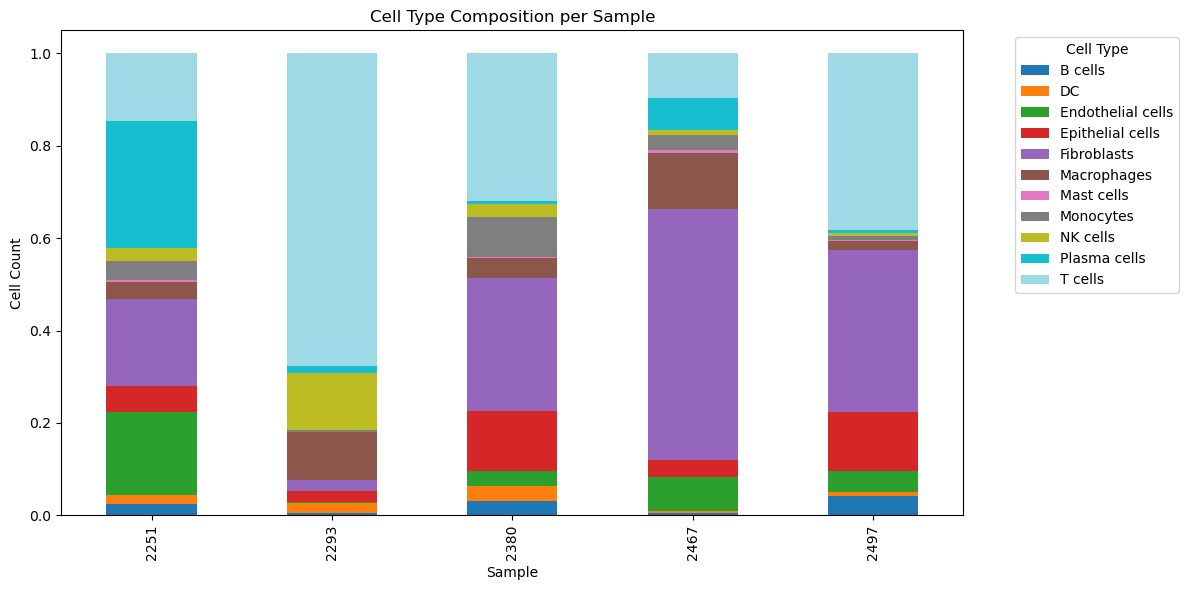

In [10]:
ct = pd.crosstab(
    adata.obs[format_col_def['obs']['sample_col']], 
    adata.obs[format_col_def['obs']['cell_type_col']]
    )
with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.width', None,
    'display.max_colwidth', None
):
    print(ct)

count_df = adata.obs.groupby([
    adata.obs[format_col_def['obs']['sample_col']], 
    adata.obs[format_col_def['obs']['cell_type_col']]
    ]).size().reset_index(name='count')
pivot_df = count_df.pivot(
    index=format_col_def['obs']['sample_col'],
    columns=format_col_def['obs']['cell_type_col'],
    values='count').fillna(0)

pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(12, 6))
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20', ax=ax)

plt.xlabel('Sample')
plt.ylabel('Cell Count')
plt.title('Cell Type Composition per Sample')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Stim Stats

In [11]:
ct = pd.crosstab(
    adata.obs[format_col_def['obs']['sample_col']], 
    adata.obs[format_col_def['obs']['stim_col']])
with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.width', None,
    'display.max_colwidth', None
):
    print(ct)

stim       dissociated
sample_id             
2251              6819
2293              7734
2380              4732
2467              5161
2497              7208


### Perform train test split holding out samples completely

In [12]:
unique_sample_ids = adata.obs[format_col_def['obs']['sample_col']].unique()
print(f"All unique sample IDs: {unique_sample_ids}")

random.seed(DATASPLIT_SEED)

n_test_samples = int(np.ceil(len(unique_sample_ids) * TEST_SIZE))
test_sample_ids = random.sample(list(unique_sample_ids), n_test_samples)
print(f"Test sample ID(s) selected for hold-out as test dataset: {test_sample_ids}")

test_idx = np.where(adata.obs[format_col_def['obs']['sample_col']].isin(test_sample_ids))[0]
test_idx = adata.obs.index[test_idx]
adata.obs.loc[:, format_col_def['obs']['datasplit_col']] = 'Train'
adata.obs.loc[test_idx, format_col_def['obs']['datasplit_col']] = 'Test'

print("\n\nData Split Sanity Check Tabulation")
contingency_table = pd.crosstab(
    adata.obs[format_col_def['obs']['sample_col']], 
    adata.obs[format_col_def['obs']['datasplit_col']])
with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.width', None,
    'display.max_colwidth', None
):
    print(contingency_table)

All unique sample IDs: ['2251' '2293' '2380' '2467' '2497']
Test sample ID(s) selected for hold-out as test dataset: ['2251']


Data Split Sanity Check Tabulation
isTraining  Test  Train
sample_id              
2251        6819      0
2293           0   7734
2380           0   4732
2467           0   5161
2497           0   7208


## Make Pseudobulks

In [13]:
augmentor = SCAugmentor(
    adata=adata,
    sample_col=format_col_def['obs']['sample_col'],
    split_col=format_col_def['obs']['datasplit_col'],
    celltype_col=format_col_def['obs']['cell_type_col'],
    gene_id_col=format_col_def['var']['gene_id_col'],
)

-----------------------------------------------
PseudoBulkAugmentor initialised with:
  #Samples : 5
  #Stims   : 1
  #Splits  : 2
  #Cell types : 11

Contingency table (sample × split):
isTraining  Test  Train
sample_id              
2251        6819      0
2293           0   7734
2380           0   4732
2467           0   5161
2497           0   7208
-----------------------------------------------



In [14]:
augmentor.configure_random_pseudobulks(
    n_bulks=1_000, # 1, 000 generated per sample
    n_cells=5_000, # 5, 000 cells per pseudobulk
    mean=5.0, # Mean for log-normal distribution sampling
    variance_range=(1.0, 3.0), # Variance range for log-normal distribution sampling
)
augmentor.configure_realistic_pseudobulks(
    n_bulks=0, # No realistic pseudobulks generated
)
augmentor.configure_singlecell_pseudobulks(
    n_bulks=100, # 100 pseudobulks generated per sample per cell type 
    n_cells=5_000,
    background_prop=0.01,
)

augmentor.configure_pseudobulk_noise(
    cell_noise=(0, 0.1), # randomly generated noise with log-normal mean 0 and std 0.1
    use_sample_noise=False, # Do not use sample noise
)

print("Random  :", augmentor._random_cfg)
print("Realistic:", augmentor._realistic_cfg)
print("Single  :", augmentor._single_cfg)
print("Noise   :", augmentor._noise_cfg)

Random  : {'n_bulks': 1000, 'n_cells': 5000, 'mean': 5.0, 'variance_range': (1.0, 3.0)}
Realistic: {'n_bulks': 0, 'n_cells': 5000, 'min_corr': 0.8}
Single  : {'n_bulks': 100, 'n_cells': 5000, 'background_prop': 0.01}
Noise   : {'cell_noise': [array([1.12037335, 0.97922104, 0.96106241, ..., 1.02409173, 1.05162842,
       0.91471542]), array([0.95930547, 1.09559719, 1.26964897, ..., 1.02812291, 1.02059259,
       1.00408478]), array([1.04424996, 0.95570117, 0.87224588, ..., 1.02147253, 1.03638553,
       0.86666704]), array([1.11266814, 0.88170535, 0.97051211, ..., 0.94308371, 1.09337872,
       0.94370873]), array([0.98298669, 1.18738918, 0.91302566, ..., 1.00050599, 0.89001177,
       0.96301283]), array([1.03703644, 0.95293476, 1.02943674, ..., 1.03612598, 0.89777767,
       1.12666842]), array([0.93037077, 1.04590608, 1.21358927, ..., 1.13230896, 0.98916273,
       1.00049909]), array([1.02520179, 1.11726754, 1.01461472, ..., 0.99683019, 1.06663779,
       1.03639328]), array([0.9149

In [15]:
augmentor.run(
    save_path=SC_AUGMENTED_DATA_PATH,
    augmentation_name=f'{ACCESSION}_augmented',
    seed=42,
    overwrite=True,
)

Generating pseudo‑bulk profiles for sample 2251, stim dissociated, split Test …
  >Generating random‑prop pseudo‑bulks…


100%|██████████| 1000/1000 [00:23<00:00, 42.35it/s]


  >Generating single‑cell‑dominant pseudo‑bulks…


100%|██████████| 1100/1100 [00:27<00:00, 40.35it/s]


  Done for 2251, dissociated, Test.

Generating pseudo‑bulk profiles for sample 2251, stim dissociated, split Train …
>No matching cells – skipping.
Generating pseudo‑bulk profiles for sample 2293, stim dissociated, split Test …
>No matching cells – skipping.
Generating pseudo‑bulk profiles for sample 2293, stim dissociated, split Train …
  >Generating random‑prop pseudo‑bulks…


100%|██████████| 1000/1000 [00:23<00:00, 42.36it/s]


  >Generating single‑cell‑dominant pseudo‑bulks…


100%|██████████| 1100/1100 [00:27<00:00, 40.25it/s]


  Done for 2293, dissociated, Train.

Generating pseudo‑bulk profiles for sample 2380, stim dissociated, split Test …
>No matching cells – skipping.
Generating pseudo‑bulk profiles for sample 2380, stim dissociated, split Train …
  >Generating random‑prop pseudo‑bulks…


100%|██████████| 1000/1000 [00:23<00:00, 43.20it/s]


  >Generating single‑cell‑dominant pseudo‑bulks…


100%|██████████| 1100/1100 [00:25<00:00, 43.76it/s]


  Done for 2380, dissociated, Train.

Generating pseudo‑bulk profiles for sample 2467, stim dissociated, split Test …
>No matching cells – skipping.
Generating pseudo‑bulk profiles for sample 2467, stim dissociated, split Train …
  >Generating random‑prop pseudo‑bulks…


100%|██████████| 1000/1000 [00:21<00:00, 46.00it/s]


  >Generating single‑cell‑dominant pseudo‑bulks…


100%|██████████| 1100/1100 [00:24<00:00, 45.20it/s]


  Done for 2467, dissociated, Train.

Generating pseudo‑bulk profiles for sample 2497, stim dissociated, split Test …
>No matching cells – skipping.
Generating pseudo‑bulk profiles for sample 2497, stim dissociated, split Train …
  >Generating random‑prop pseudo‑bulks…


100%|██████████| 1000/1000 [00:21<00:00, 45.72it/s]


  >Generating single‑cell‑dominant pseudo‑bulks…


100%|██████████| 1100/1100 [00:24<00:00, 45.21it/s]


  Done for 2497, dissociated, Train.

